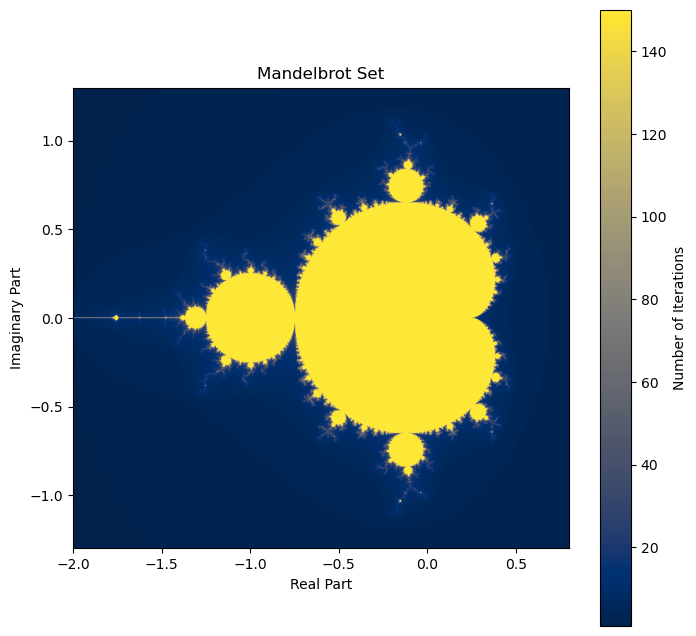

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, ttest_ind
from scipy.stats.qmc import LatinHypercube, scale, Sobol
import statistics

'''
EXERCISE 1
'''
# Define parameters
w, h = 1000, 1000 # Image size
x_min, x_max = -2.0, 0.8  # Range real part
y_min, y_max = -1.3, 1.3  # Range imaginary part
max_i = 150  # Maximum number of iterations

mandelbrot_set = np.zeros((h, w))

# Generate Mandelbrot set
for x in range(w):
    real = x_min + ((x / w) * (x_max - x_min))
    for y in range(h):
        # Give coordinates to complex number
        imag = y_min + ((y / h) * (y_max - y_min))
        c = complex(real, imag)
 
        # Initialize z
        z = complex()
        iter = 0

        # Run iterations
        while abs(z) <= 2 and iter < max_i:
            z = (z * z) + c
            iter += 1

        # Insert corresponding number of iterations in matrix
        mandelbrot_set[y, x] = iter

# Print picture
plt.figure(figsize = (8, 8))
plt.imshow(mandelbrot_set, extent = (x_min, x_max, y_min, y_max), cmap = 'cividis')
plt.colorbar(label = 'Number of Iterations')
plt.title("Mandelbrot Set")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.show()

In [2]:
'''
EXERCISE 2
'''
def insidetheset(c, max_i): # Define function to determine if a given c is in the set does not deviate for a given number of iterations
    
    z = complex()
    
    for i in range(max_i):
        if abs(z) > 2:
            return False
        z = (z * z) + c

    return True

def slope_curve(A, area_method): # Define function that calculates the slope of the curve of the estimated relative error in the area computation for the number of iterations

    slopes = []
    log_i = np.log(np.array(list_i))

    for s in range(samples):
        diff = []
        for i in list_i:
            diff.append(abs(area_method(max(list_s), i) - A) / A) # Calculate the relative difference in the estimated area and its 'true value' for every iteration number for the max number of siulation, to compare methods
        log_diff = np.log(np.array(diff))
        slope = linregress(log_i, log_diff).slope # Convert both to log to fit a power law distribution through linregress
        slopes.append(slope)

    mean_slope = np.mean(slopes)
    variance_slope = statistics.variance(slopes)
    print(f'The average slope on a fitted power-law curve of the line corresponding to s = {max(list_s)} is equal to {mean_slope}, with a variance of {variance_slope}')
    return slopes

def plot_diff(A, area_method): # Function that plots the relative error in area estimation for every i and every s for a given method

    dic_diff = {s: [] for s in list_s}

    for i in list_i:
        for s in list_s:
            diff = abs(area_method(s, i) - A) / A
            dic_diff[s].append(diff)
    
    # Plot the differences with A_{M} for every estimated area
    for index, (s, diff) in enumerate(dic_diff.items()):
        plt.plot(list_i, diff, color = plt.cm.gray(1-(0.1 + 0.6 * (index / (len(list_s) - 1)))), label = f's = {s}')
    plt.xlabel('Number of iterations j')
    plt.ylabel('Relative error in A_{j, s} - A_{M}')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Define general parameters
x_min, x_max = -2.0, 0.8  # Range real part
y_min, y_max = -1.3, 1.3  # Range imaginary part
# Create lists of all i and s
steps = 150
list_i = [1]
list_s = [16, 64, 256, 1024, 4096] # These number have been chosen to optimally use orthogonal and sobol methods
for step in range(1, steps):
    list_i.append(list_i[step - 1] + 2)
samples = 30 # Number of samples to calculate slope

A_{PR} ≅  1.5124639892578124
The average slope on a fitted power-law curve of the line corresponding to s = 4096 is equal to -0.9351110803612329, with a variance of 0.004023455495355377


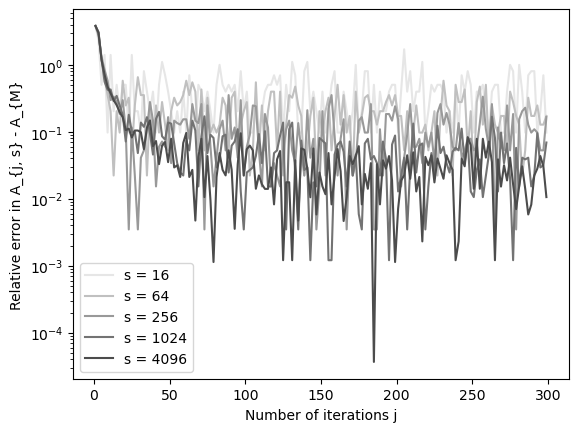

In [3]:
def area_pure_random(s, i): # Define function to calculate area through pure random method

    total_area = (x_max - x_min) * (y_max - y_min)
    samples_in_area = 0

    for _ in range(s):
        real = np.random.uniform(x_min, x_max)
        imag = np.random.uniform(y_min, y_max)
        c = complex(real, imag)
        if insidetheset(c, i):
            samples_in_area += 1

     # Area is calculated based on percentage of samples that do not deviate
    set_area = total_area * (samples_in_area / s)
    return set_area
# Calculate an estimate of A_{PR}
A_PR = area_pure_random(262144, 10000)
print('A_{PR} ≅ ', A_PR)

slopes_PR = slope_curve(A_PR, area_pure_random)

plot_diff(A_PR, area_pure_random)

A_{LH} ≅  1.515491027832031
The average slope on a fitted power-law curve of the line corresponding to s = 4096 is equal to -1.0995828341559788, with a variance of 0.003146524407483087


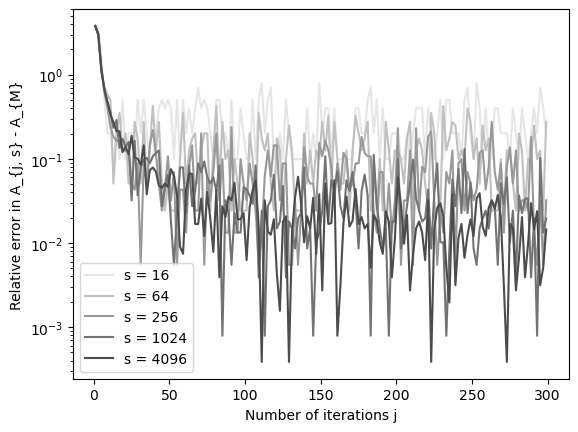

In [4]:

def area_latin(s, i): # Define function to calculate area through latin hypercube method

    total_area = (x_max - x_min) * (y_max - y_min)
    samples_in_area = 0

    sampler = LatinHypercube(d = 2) # 2 dimensions (real and imaginary)
    sample = scale(sampler.random(n = s), [x_min, y_min], [x_max, y_max]) # Scale the sample in the given x and y

    for real, imag in sample:
        c = complex(real, imag)
        if insidetheset(c, i):
            samples_in_area += 1

     # Area is calculated based on percentage of samples that do not deviate
    set_area = total_area * (samples_in_area / s)
    return set_area

A_LH = area_latin(262144, 10000)
print('A_{LH} ≅ ', A_LH)

slopes_LH = slope_curve(A_LH, area_latin)

plot_diff(A_LH, area_latin)

A_{O} ≅  1.3927154541015623
The average slope on a fitted power-law curve of the line corresponding to s = 4096 is equal to -1.1671789346863126, with a variance of 0.0009894593987756532


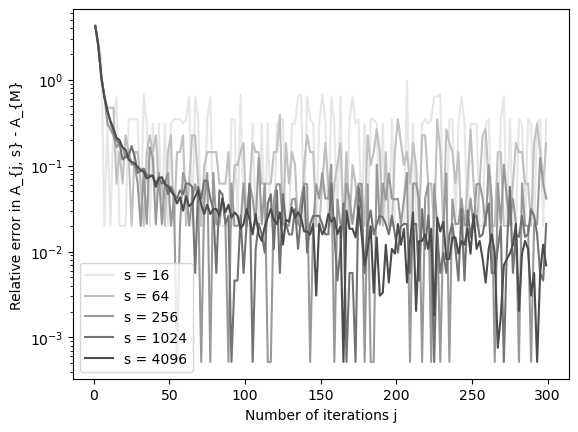

In [5]:

def area_orthogonal(s, i): # Define function to calculate area through orthogonal method

    total_area = (x_max - x_min) * (y_max - y_min)
    samples_in_area = 0

    n = int(np.sqrt(s)) # This is done to obtain s samples
    if n * n != s:
        raise ValueError('s should be perfect square for orthogonal sampling')

    x_intervals = np.linspace(x_min, x_max, n + 1)
    y_intervals = np.linspace(y_min, y_max, n + 1)

    for j in range(n):
        for k in range(n):
            real = np.random.uniform(x_intervals[j], x_intervals[j+1])
            imag = np.random.uniform(x_intervals[k], x_intervals[k+1])
            c = complex(real, imag)
            if insidetheset(c, i):
                samples_in_area += 1

     # Area is calculated based on percentage of samples that do not deviate
    set_area = total_area * (samples_in_area / s)
    return set_area

A_O = area_orthogonal(262144, 10000)
print('A_{O} ≅ ', A_O)

slopes_O = slope_curve(A_O, area_orthogonal)

plot_diff(A_O, area_orthogonal)

A_{S} ≅  1.5071041870117186
The average slope on a fitted power-law curve of the line corresponding to s = 4096 is equal to -1.200938310167521, with a variance of 0.0017745002769909233


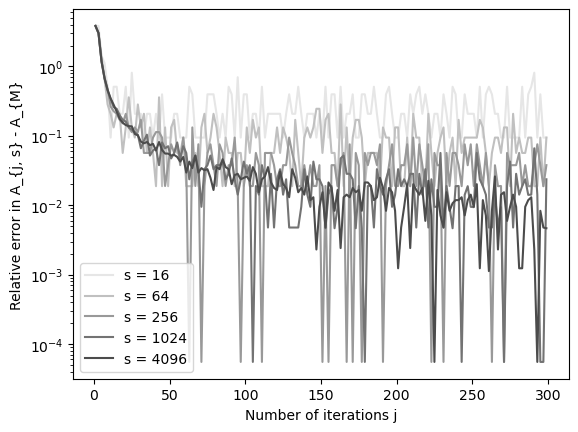

In [6]:

def area_sobol(s, i): # Define function to calculate area through sobol method

    total_area = (x_max - x_min) * (y_max - y_min)
    samples_in_area = 0

    sampler = Sobol(d = 2)
    sample = scale(sampler.random(n = s), [x_min, y_min], [x_max, y_max])

    for real, imag in sample:
        c = complex(real, imag)
        if insidetheset(c, i):
            samples_in_area += 1

     # Area is calculated based on percentage of samples that do not deviate
    set_area = total_area * (samples_in_area / s)
    return set_area

A_S = area_sobol(262144, 10000)
print('A_{S} ≅ ', A_S)

slopes_S = slope_curve(A_S, area_sobol)

plot_diff(A_S, area_sobol)

In [7]:
slopes_list = [slopes_PR, slopes_LH, slopes_O, slopes_S]
names_list = ['Pure Random', 'Latin Hypercube', 'Orthogonal', 'Sobol']

alpha = 0.05 # Set alpha for t test on the average slopes

# Test for the difference in convergence for every method against the others through 2-sided Welch's t-test and print results
for index, sl1 in enumerate(slopes_list[:-1]):
    for sl2 in slopes_list[index+1:]:
        t_stat, p_value = ttest_ind(sl1, sl2, equal_var = False)
        print(f'H0: there is no significant difference in convergence between {names_list[slopes_list.index(sl1)]} and {names_list[slopes_list.index(sl2)]} methods')
        if p_value < alpha:
            print(f'H0 is rejected with P-value = {p_value}')

            higher_conv = sl1 if max(abs(np.mean(sl1)), abs(np.mean(sl2))) == abs(np.mean(sl1)) else sl2
            lower_conv = sl1 if min(abs(np.mean(sl1)), abs(np.mean(sl2))) == abs(np.mean(sl1)) else sl2
            print(f'{names_list[slopes_list.index(higher_conv)]} method has a higher convergence compared to {names_list[slopes_list.index(lower_conv)]}')
        else:
            print(f'H0 is not rejected with P-value = {p_value}')
            print(f'{names_list[slopes_list.index(sl1)]} does not significantly differ in convergence compared to {names_list[slopes_list.index(sl2)]}')
        print('---------')

H0: there is no significant difference in convergence between Pure Random and Latin Hypercube methods
H0 is rejected with P-value = 3.584273139857239e-15
Latin Hypercube method has a higher convergence compared to Pure Random
---------
H0: there is no significant difference in convergence between Pure Random and Orthogonal methods
H0 is rejected with P-value = 1.924649470947267e-21
Orthogonal method has a higher convergence compared to Pure Random
---------
H0: there is no significant difference in convergence between Pure Random and Sobol methods
H0 is rejected with P-value = 9.347719457340994e-25
Sobol method has a higher convergence compared to Pure Random
---------
H0: there is no significant difference in convergence between Latin Hypercube and Orthogonal methods
H0 is rejected with P-value = 6.872276949794733e-07
Orthogonal method has a higher convergence compared to Latin Hypercube
---------
H0: there is no significant difference in convergence between Latin Hypercube and Sobol 